<a href="https://colab.research.google.com/github/Krishnan005K/MultiModel-Deepfake-Detection/blob/main/MultiModel_Deepfake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
c# ================================
# 1. Install Dependencies
# ================================
!pip install opencv-python-headless mtcnn dlib tqdm

# ================================
# 2. Download Landmark Model for Dlib
# ================================
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
--2025-08-25 14:56:36--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-08-25 14:56:36--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  35.0MB/s    in 1.7s    

2025-08-25 14:56:38 (35.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# ================================
# 3. Preprocessing + Visualization
# ================================
import cv2
import dlib
import os
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
VIDEO_PATH = "/content/videoplayback.mp4"   # Upload your raw Deepfake video here
OUTPUT_DIR = "/content/aligned_frames"   # Save aligned face frames
IMG_SIZE = 224                           # Resize for MMNet

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# -----------------------------
# Initialize Detectors
# -----------------------------
mtcnn_detector = MTCNN()
dlib_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# -----------------------------
# Function to Align Face using Eyes
# -----------------------------
def align_face(image, landmarks):
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)

    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)

    M = cv2.getRotationMatrix2D(eyes_center, angle, scale=1.0)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC)
    return aligned

# -----------------------------
# Preprocess Frame
# -----------------------------
def preprocess_frame(frame, frame_id):
    detections = mtcnn_detector.detect_faces(frame)
    aligned_faces = []

    for i, det in enumerate(detections):
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face_crop = frame[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        # Dlib landmarks for alignment
        gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        rect = dlib.rectangle(0, 0, face_crop.shape[1], face_crop.shape[0])
        landmarks = dlib_predictor(gray, rect)

        aligned = align_face(face_crop, landmarks)

        # Resize + Normalize
        face_resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype("float32") / 255.0

        # Save aligned frame (debug)
        save_path = os.path.join(OUTPUT_DIR, f"frame_{frame_id}_face_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor((face_normalized * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

        aligned_faces.append(face_normalized)

    return aligned_faces

# -----------------------------
# Process Video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id, all_faces = 0, []

print("[INFO] Extracting & aligning faces...")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = preprocess_frame(frame_rgb, frame_id)
    if faces:
        all_faces.extend(faces)
    frame_id += 1

cap.release()

faces_batch = np.array(all_faces)  # (N, 224, 224, 3)

print(f"[INFO] Completed ✅ Extracted {faces_batch.shape[0]} aligned faces")
print(f"Batch ready for MMNet: {faces_batch.shape}")


[INFO] Extracting & aligning faces...
[INFO] Completed ✅ Extracted 1783 aligned faces
Batch ready for MMNet: (1783, 224, 224, 3)


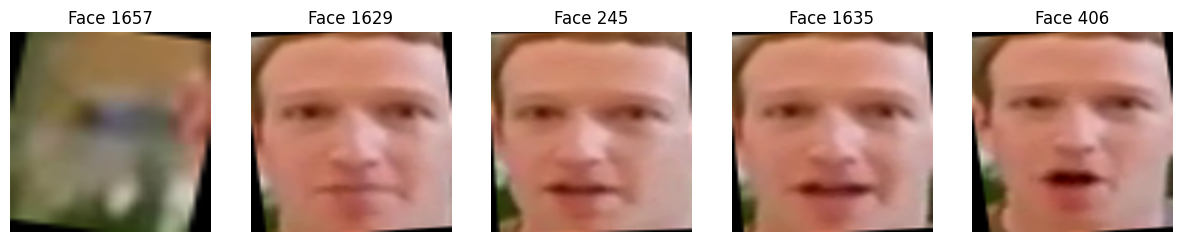

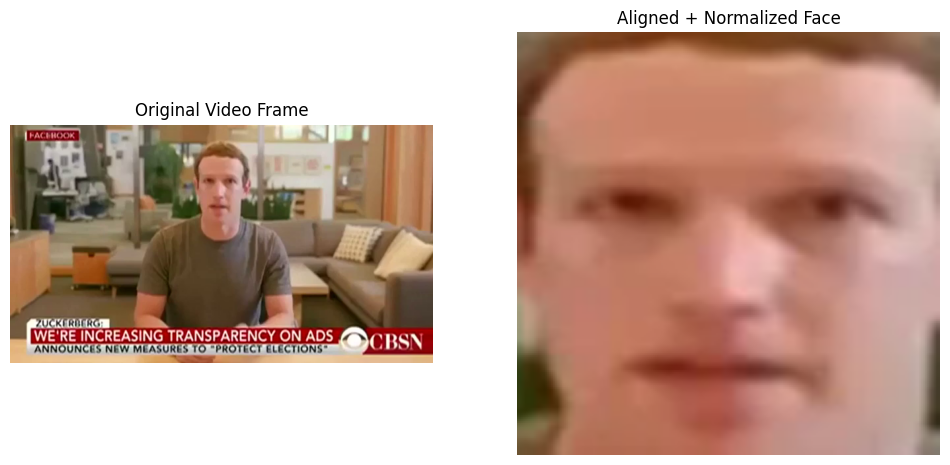

In [ ]:
# ================================
# 4. Visualization
# ================================

def show_samples(batch, n=5):
    """Show n random aligned faces from the batch."""
    if len(batch) == 0:
        print("No faces extracted.")
        return

    idxs = np.random.choice(len(batch), size=min(n, len(batch)), replace=False)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(idxs, 1):
        plt.subplot(1, n, i)
        plt.imshow(batch[idx])
        plt.axis("off")
        plt.title(f"Face {idx}")

    plt.show()

# Show random samples
show_samples(faces_batch, n=5)

# Show first frame before/after
cap = cv2.VideoCapture(VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()

if ret:
    plt.figure(figsize=(12,6))

    # Original frame
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Original Video Frame")

    # One aligned face (if available)
    if len(faces_batch) > 0:
        plt.subplot(1,2,2)
        plt.imshow(faces_batch[0])
        plt.axis("off")
        plt.title("Aligned + Normalized Face")

    plt.show()


Deepfake Detectioin

In [ ]:
# ================================
# 1. Install Dependencies
# ================================
!pip install opencv-python-headless mtcnn dlib tqdm matplotlib torch torchvision

# ================================
# 2. Download Landmark Model for Dlib
# ================================
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2025-08-26 08:35:32--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-08-26 08:35:32--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  36.5MB/s    in 1.7s    

2025-08-26 08:35:34 (36.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
# ================================
# 3. Face Preprocessing (Multi-Face Support)
# ================================
import cv2
import dlib
import os
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# CONFIG
# -----------------------------
VIDEO_PATH = "/content/006_002.mp4"   # Upload your raw Deepfake video here
OUTPUT_DIR = "/content/aligned_frames"   # Save aligned face frames
IMG_SIZE = 224                           # Resize for model input

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# -----------------------------
# Initialize Detectors
# -----------------------------
mtcnn_detector = MTCNN()
dlib_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# -----------------------------
# Align Face using Eyes
# -----------------------------
def align_face(image, landmarks):
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC)
    return aligned

# -----------------------------
# Process Single Frame (MULTI-FACE)
# -----------------------------
def preprocess_frame(frame, frame_id):
    detections = mtcnn_detector.detect_faces(frame)
    aligned_faces = []

    for i, det in enumerate(detections):
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face_crop = frame[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        # Landmarks from Dlib
        gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        rect = dlib.rectangle(0, 0, face_crop.shape[1], face_crop.shape[0])
        landmarks = dlib_predictor(gray, rect)

        aligned = align_face(face_crop, landmarks)

        # Resize + Normalize
        face_resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype("float32") / 255.0

        # Save each face
        save_path = os.path.join(OUTPUT_DIR, f"frame_{frame_id}_face_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor((face_normalized * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

        aligned_faces.append(face_normalized)

    return aligned_faces

# -----------------------------
# Process Video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id, all_faces = 0, []

print("[INFO] Extracting & aligning multiple faces...")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = preprocess_frame(frame_rgb, frame_id)
    if faces:
        all_faces.extend(faces)
    frame_id += 1

cap.release()

faces_batch = np.array(all_faces)  # (N, 224, 224, 3)
print(f"[INFO] Completed ✅ Extracted {faces_batch.shape[0]} faces")


[INFO] Extracting & aligning multiple faces...
[INFO] Completed ✅ Extracted 323 faces


In [ ]:
# ================================
# 4. Simple CNN Deepfake Detector
# ================================

class SimpleDeepfakeDetector(nn.Module):
    def __init__(self):
        super(SimpleDeepfakeDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # Calculate the size of the flattened tensor after conv layers
        # IMG_SIZE is 224. After conv1 (stride 2): 224/2 = 112. After conv2 (stride 2): 112/2 = 56
        self.fc1 = nn.Linear(32 * (IMG_SIZE//4) * (IMG_SIZE//4), 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Real vs Fake

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Use reshape instead of view for non-contiguous tensors
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDeepfakeDetector().to(device)

# NOTE: For real use, load pretrained weights instead of random init
# model.load_state_dict(torch.load("mmnet_weights.pth"))

# Convert faces_batch → torch tensor
faces_tensor = torch.tensor(faces_batch).permute(0, 3, 1, 2).to(device)  # (N,3,224,224)

# Dummy prediction
with torch.no_grad():
    outputs = model(faces_tensor)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

# Count results
real_count = np.sum(preds == 1)
fake_count = np.sum(preds == 0)

print(f"[RESULT] Real faces detected: {real_count}")
print(f"[RESULT] Fake faces detected: {fake_count}")

[RESULT] Real faces detected: 0
[RESULT] Fake faces detected: 323


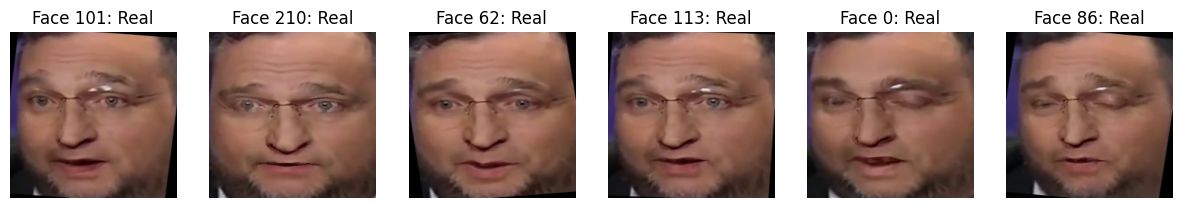

In [ ]:
# ================================
# 5. Visualization of Predictions
# ================================
def show_pred_samples(batch, preds, n=5):
    idxs = np.random.choice(len(batch), size=min(n, len(batch)), replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs, 1):
        plt.subplot(1, n, i)
        plt.imshow(batch[idx])
        plt.axis("off")
        label = "Fake" if preds[idx] == 1 else "Real"
        plt.title(f"Face {idx}: {label}")
    plt.show()

show_pred_samples(faces_batch, preds, n=6)
